# Исследование влияния размеров обучающей и проверочной выборок на качество обучения

**Создайте модель для распознавания рукописных цифр из набора MNIST (можно воспользоваться ноутбуком 1-го занятия) и проведите ряд тестов:**

Запустите сеть с различными размерами обучающей и проверочной выборок:

1. Размер `test_size=0.1`
2. Размер `test_size=0.5`
3. Размер `test_size=0.9`

Напишите выводы, как изменение `test_size` влияет на точность сети.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import History
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils

from PIL import Image

from matplotlib import pyplot as plt
%matplotlib inline

Задать количество эпох для обучения.

In [2]:
EPOCHS = 15

Создать датафрейм для хранения результатов исследования.

In [3]:
report = pd.DataFrame(
    index=(0.1, 0.5, 0.9),
    columns=('Train', 'Validation', 'Test')
)

## Подготовка данных

Загрузка данных MNIST:

In [4]:
(x_org, y_org), (x_test_org, y_test_org) = mnist.load_data()

In [5]:
print(f"{x_org.shape}, {x_test_org.shape}")

(60000, 28, 28), (10000, 28, 28)


Отобразить примеры цифр из набора

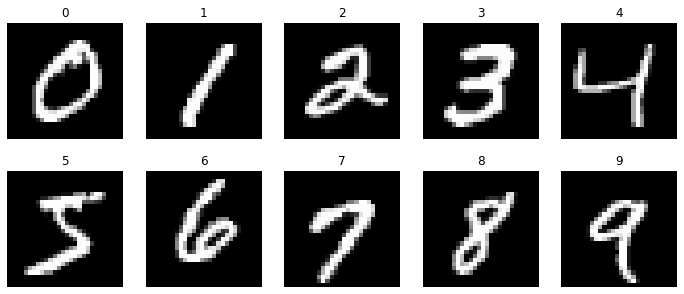

In [6]:
digits = np.unique(y_org)

_, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for digit, ax in zip(digits, axes):
    ax.imshow(
        Image.fromarray(x_org[y_org == digit][0]).convert('RGB')
    )

    ax.set_title(str(digit))
    ax.set_axis_off()

plt.show();

Изменить формат входных изображений:

In [7]:
x = x_org.reshape(-1, 28*28).astype(np.float32) / 255
x_test = x_test_org.reshape(-1, 28*28).astype(np.float32) / 255

Преобразовать ответы в унитарный код (one-hot)

In [8]:
y = utils.to_categorical(y_org, 10)
y_test = utils.to_categorical(y_test_org, 10)

In [9]:
print(f"{y.shape}, {y_test.shape}")

(60000, 10), (10000, 10)


## Создание нейронной сети

Вспомогательный класс для создания нейронной сети заданной архитектуры.

In [10]:
class Net:

    @staticmethod
    def build():
        model = Sequential()
        model.add(Dense(800, input_dim=28*28))
        model.add(Activation('relu'))
        model.add(Dense(400))
        model.add(Activation('relu'))
        model.add(Dense(10))
        model.add(Activation('softmax'))

        model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(),
            metrics=['accuracy']
        )

        return model


## Исследование влияния размера проверочной выборки

### Размер проверочной выборки равен 0.1 от общего размера

Выделить тестовую и валидационную выборки.

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1)

Создать нейронную сеть.

In [12]:
model_01 = Net.build()
print(model_01.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 800)               628000    
_________________________________________________________________
activation (Activation)      (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               320400    
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                4010      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 952,410
Trainable params: 952,410
Non-trainable params: 0
__________________________________________________

Обучить нейронную сеть.

In [13]:
history_01 = model_01.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/15
422/422 [==============================] - 6s 13ms/step - loss: 0.2182 - accuracy: 0.9346 - val_loss: 0.1108 - val_accuracy: 0.9672
Epoch 2/15
422/422 [==============================] - 5s 13ms/step - loss: 0.0786 - accuracy: 0.9757 - val_loss: 0.0954 - val_accuracy: 0.9712
Epoch 3/15
422/422 [==============================] - 5s 12ms/step - loss: 0.0496 - accuracy: 0.9844 - val_loss: 0.0838 - val_accuracy: 0.9765
Epoch 4/15
422/422 [==============================] - 5s 13ms/step - loss: 0.0343 - accuracy: 0.9889 - val_loss: 0.0856 - val_accuracy: 0.9755
Epoch 5/15
422/422 [==============================] - 5s 12ms/step - loss: 0.0269 - accuracy: 0.9910 - val_loss: 0.0851 - val_accuracy: 0.9762
Epoch 6/15
422/422 [==============================] - 5s 12ms/step - loss: 0.0202 - accuracy: 0.9935 - val_loss: 0.0890 - val_accuracy: 0.9783
Epoch 7/15
422/422 [==============================] - 5s 13ms/step - loss: 0.0180 - accuracy: 0.9939 - val_loss: 0.1009 - val_accuracy: 0.9773

Отобразить график изменения loss и accuracy в процессе обучения.

In [14]:
def plot_history(history: History):
    _, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(
        history.epoch,
        history.history['loss'],
        color='steelblue',
        label='loss'
    )
    axes[0].plot(
        history.epoch,
        history.history['val_loss'],
        color='darkblue',
        label='val_loss'
    )
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(
        history.epoch,
        history.history['accuracy'],
        color='salmon',
        label='accuracy'
    )
    axes[1].plot(
        history.epoch,
        history.history['val_accuracy'],
        color='darkred',
        label='val_accuracy'
    )
    axes[1].set_ylabel('accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].grid(True)
    axes[1].legend()

    plt.show()

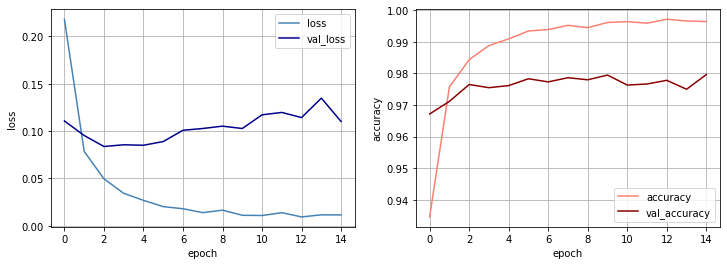

In [15]:
plot_history(history_01);

Сохранить и загрузить веса нейронной сети.

In [16]:
path = Path.home() / 'aiu-02-mnist-ultra-light-model-01.h5'

model_01.save_weights(path)
model_01.load_weights(path)

Получить данные на тестовой выборке.

In [17]:
score = model_01.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.0870 - accuracy: 0.9815


Занести результаты исследования в таблицу.

In [18]:
report.loc[0.1, :] = (
    history_01.history['accuracy'][-1],
    history_01.history['val_accuracy'][-1],
    score[1],
)

### Размер проверочной выборки равен 0.5 от общего размера

Выделить тестовую и валидационную выборки.

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.5)

Создать нейронную сеть.

In [20]:
model_05 = Net.build()
print(model_05.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 800)               628000    
_________________________________________________________________
activation_3 (Activation)    (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 400)               320400    
_________________________________________________________________
activation_4 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                4010      
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
Total params: 952,410
Trainable params: 952,410
Non-trainable params: 0
________________________________________________

Обучить нейронную сеть.

In [21]:
history_05 = model_05.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/15
235/235 [==============================] - 6s 25ms/step - loss: 0.2911 - accuracy: 0.9154 - val_loss: 0.1441 - val_accuracy: 0.9561
Epoch 2/15
235/235 [==============================] - 4s 17ms/step - loss: 0.1094 - accuracy: 0.9671 - val_loss: 0.1049 - val_accuracy: 0.9671
Epoch 3/15
235/235 [==============================] - 4s 17ms/step - loss: 0.0627 - accuracy: 0.9805 - val_loss: 0.1025 - val_accuracy: 0.9681
Epoch 4/15
235/235 [==============================] - 4s 17ms/step - loss: 0.0398 - accuracy: 0.9878 - val_loss: 0.0886 - val_accuracy: 0.9725
Epoch 5/15
235/235 [==============================] - 4s 17ms/step - loss: 0.0283 - accuracy: 0.9906 - val_loss: 0.1120 - val_accuracy: 0.9688
Epoch 6/15
235/235 [==============================] - 4s 17ms/step - loss: 0.0197 - accuracy: 0.9937 - val_loss: 0.1022 - val_accuracy: 0.9726
Epoch 7/15
235/235 [==============================] - 4s 17ms/step - loss: 0.0212 - accuracy: 0.9927 - val_loss: 0.1001 - val_accuracy: 0.9742

Отобразить график изменения loss и accuracy в процессе обучения.

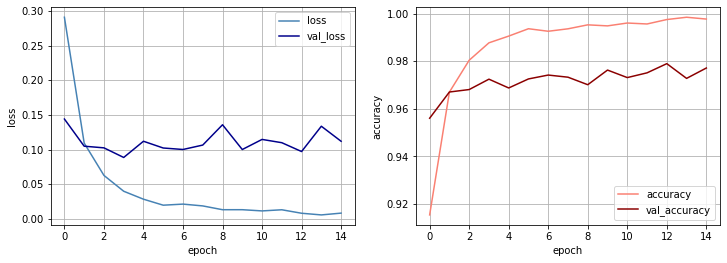

In [22]:
plot_history(history_05);

Сохранить и загрузить веса нейронной сети.

In [23]:
path = Path.home() / 'aiu-02-mnist-ultra-light-model-05.h5'

model_05.save_weights(path)
model_05.load_weights(path)

Получить данные на тестовой выборке.

In [24]:
score = model_05.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.1052 - accuracy: 0.9767


Занести результаты исследования в таблицу.

In [25]:
report.loc[0.5, :] = (
    history_05.history['accuracy'][-1],
    history_05.history['val_accuracy'][-1],
    score[1],
)

### Размер проверочной выборки равен 0.9 от общего размера

Выделить тестовую и валидационную выборки.

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.9)

Создать нейронную сеть.

In [27]:
model_09 = Net.build()
print(model_09.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 800)               628000    
_________________________________________________________________
activation_6 (Activation)    (None, 800)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 400)               320400    
_________________________________________________________________
activation_7 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                4010      
_________________________________________________________________
activation_8 (Activation)    (None, 10)                0         
Total params: 952,410
Trainable params: 952,410
Non-trainable params: 0
________________________________________________

Обучить нейронную сеть.

In [28]:
history_09 = model_09.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/15
47/47 [==============================] - 6s 131ms/step - loss: 0.6162 - accuracy: 0.8258 - val_loss: 0.3186 - val_accuracy: 0.9047
Epoch 2/15
47/47 [==============================] - 3s 57ms/step - loss: 0.2190 - accuracy: 0.9370 - val_loss: 0.2349 - val_accuracy: 0.9296
Epoch 3/15
47/47 [==============================] - 3s 56ms/step - loss: 0.1338 - accuracy: 0.9617 - val_loss: 0.1920 - val_accuracy: 0.9418
Epoch 4/15
47/47 [==============================] - 3s 57ms/step - loss: 0.0842 - accuracy: 0.9767 - val_loss: 0.2094 - val_accuracy: 0.9377
Epoch 5/15
47/47 [==============================] - 3s 60ms/step - loss: 0.0489 - accuracy: 0.9878 - val_loss: 0.1749 - val_accuracy: 0.9488
Epoch 6/15
47/47 [==============================] - 3s 60ms/step - loss: 0.0280 - accuracy: 0.9935 - val_loss: 0.1823 - val_accuracy: 0.9482
Epoch 7/15
47/47 [==============================] - 3s 59ms/step - loss: 0.0218 - accuracy: 0.9957 - val_loss: 0.1896 - val_accuracy: 0.9482
Epoch 8/15
4

Отобразить график изменения loss и accuracy в процессе обучения.

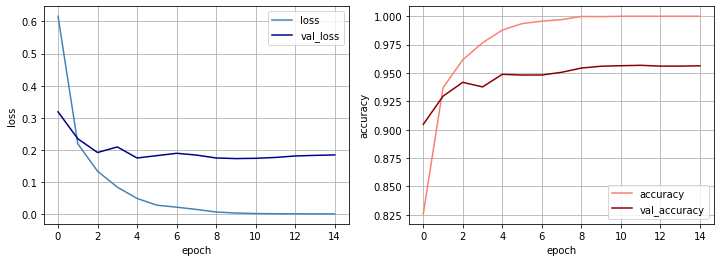

In [29]:
plot_history(history_09);

Сохранить и загрузить веса нейронной сети.

In [30]:
path = Path.home() / 'aiu-02-mnist-ultra-light-model-09.h5'

model_09.save_weights(path)
model_09.load_weights(path)

Получить данные на тестовой выборке.

In [31]:
score = model_09.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 3s 8ms/step - loss: 0.1644 - accuracy: 0.9610


Занести результаты исследования в таблицу.

In [32]:
report.loc[0.9, :] = (
    history_09.history['accuracy'][-1],
    history_09.history['val_accuracy'][-1],
    score[1],
)

## Выводы

Отобразим значения accuracy во всех трех случаях.

In [33]:
report

,Train,Validation,Test
0.1,0.996463,0.979667,0.9815
0.5,0.9978,0.9772,0.9767
0.9,1,0.956315,0.961


Отобразить столбчатую диаграмму для accuracy.

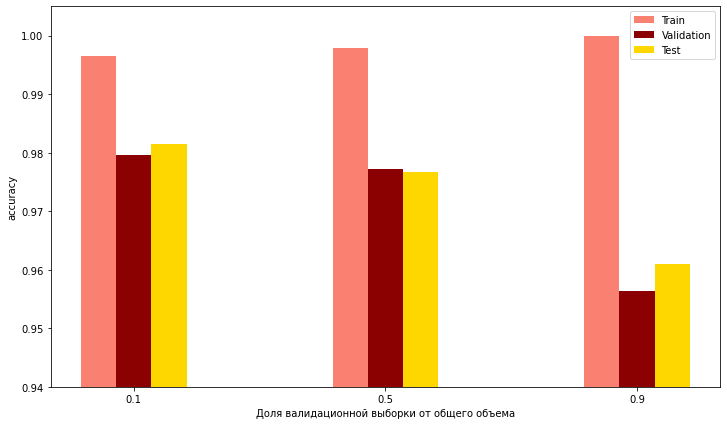

In [34]:
t = np.arange(len(report.index))
width = 0.14

_, ax = plt.subplots(figsize=(12, 7))

ax.bar(
    t - width, 
    report.loc[:, 'Train'], 
    width, 
    color='salmon',
    label='Train'
)
ax.bar(
    t, 
    report.loc[:, 'Validation'], 
    width, 
    color='darkred',
    label='Validation'
)
ax.bar(
    t + width, 
    report.loc[:, 'Test'], 
    width, 
    color='gold',
    label='Test'
)

ax.set_ylabel("accuracy")
ax.set_ylim((0.94, 1.005))
ax.set_xlabel("Доля валидационной выборки от общего объема")
ax.set_xticks(t)
ax.set_xticklabels(str(value) for value in report.index)
ax.legend()

plt.show();

Таким образом при увеличении доли валидационной выборки значение accuracy на тестовой и валидационной выборках снижается, однако accuracy возрастает для обучающей выборки. Это говорит о том, что с ростом объема валидационной выборки нейронная сеть все более теряет способность к обобщению данных и все более сильно становится переобученной.